In [22]:
import numpy as np
import matplotlib.pyplot as plt
import colour
from itertools import product

In [23]:
def create_colorspace_grid(resolution=10):
    r, g, b = np.meshgrid(np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution))

    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    return np.vstack([r, g, b]).T

def rgb_to_xyz(rgb):
    # Define the transformation matrix from sRGB to XYZ
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    
    # Linearize the gamma-corrected RGB values
    mask = rgb <= 0.04045
    rgb[mask] = rgb[mask] / 12.92
    rgb[~mask] = np.power((rgb[~mask] + 0.055) / 1.055, 2.4)

    # Convert to XYZ
    return np.dot(rgb, M.T)

def xyz_to_xy(xyz):
    sum_xyz = np.sum(xyz, axis=1) + 1e-15  # Adding a small constant to avoid division by zero
    x = xyz[:, 0] / sum_xyz
    y = xyz[:, 1] / sum_xyz
    return np.stack((x, y), axis=1)

def rgb_to_cie_xy(rgb_array):
    xyz_array = rgb_to_xyz(rgb_array)
    return xyz_to_xy(xyz_array)

def plot_colored_coordinates(xy_coords, rgb_values, title, markers=None):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_values, s=10)
    
    # # Plot the color gamut boundary 
    # n=30
    # reds_no_green = np.array(list(product(range(128, 256, n), [0], range(0, 128, n))))
    # rgb_values = reds_no_green / 255
    # xy_coords = rgb_to_cie_xy(rgb_values)
    # plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c='black', s=100, marker='x')
    if markers is not None:
        rgb_values = markers
        xy_coords = rgb_to_cie_xy(rgb_values)
        plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c='black', s=100, marker='x')
    
    plt.xlim([0, 0.8])
    plt.ylim([0, 0.9])

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.show()

def transform_to_cvd_space(rgb_array, color_vision_deficiency):
    color_vision_deficiency_model = colour.blindness.matrix_cvd_Machado2009(color_vision_deficiency, 1)
    return colour.algebra.vector_dot(color_vision_deficiency_model, rgb_array).clip(0,1)

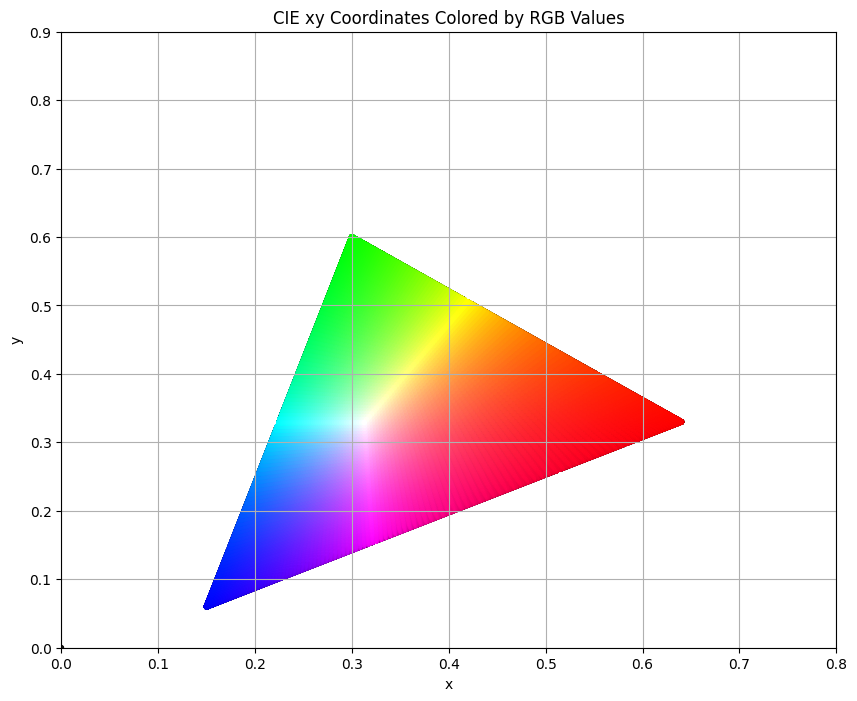

In [24]:
colors = create_colorspace_grid(60)
cie_xy_coords = rgb_to_cie_xy(colors)
plot_colored_coordinates(cie_xy_coords, colors, 'CIE xy Coordinates Colored by RGB Values')

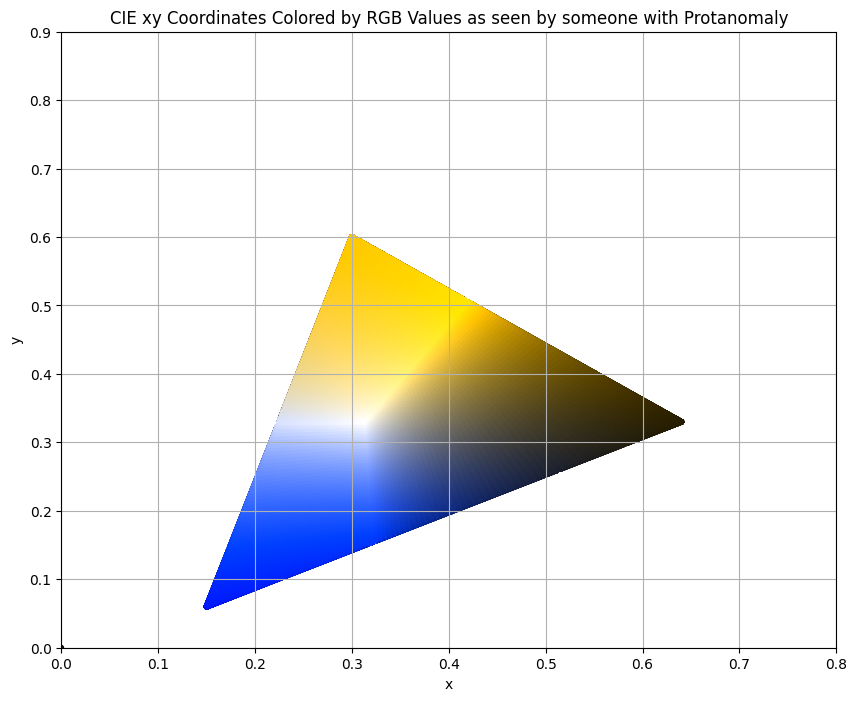

In [25]:
color_vision_deficency = 'Protanomaly'

colors_cvd = transform_to_cvd_space(colors, color_vision_deficency)

plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with {color_vision_deficency}')

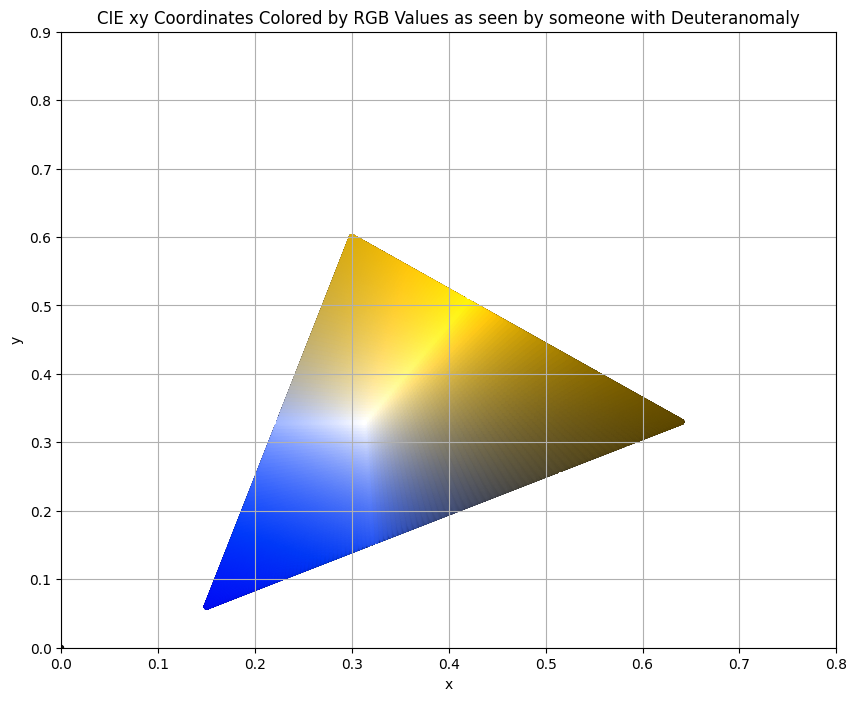

In [26]:
color_vision_deficency = 'Deuteranomaly'

colors_cvd = transform_to_cvd_space(colors, color_vision_deficency)

plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with {color_vision_deficency}')

c:\Users\Tim\miniconda3\envs\cvd\Lib\site-packages\colour\utilities\verbose.py:266: ColourUsageWarning: "Machado et al. (2009)" simulation of tritanomaly is based on the shift paradigm as an approximation to the actual phenomenon and restrain the model from trying to model tritanopia.
The pre-generated matrices are using a shift value in domain [5, 59] contrary to the domain [0, 20] used for protanomaly and deuteranomaly simulation.
  warn(*args, **kwargs)


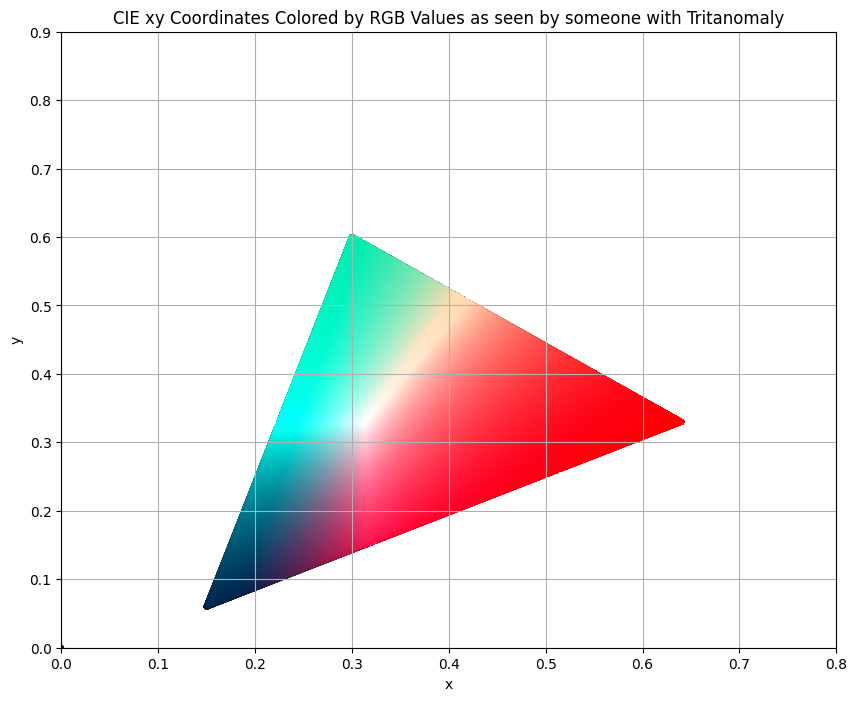

In [27]:
color_vision_deficency = 'Tritanomaly'

colors_cvd = transform_to_cvd_space(colors, color_vision_deficency)

plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with {color_vision_deficency}')

In [52]:
M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', 1)
M

array([[ 0.367322,  0.860646, -0.227968],
       [ 0.280085,  0.672501,  0.047413],
       [-0.01182 ,  0.04294 ,  0.968881]])

In [41]:
M_tilde = np.concatenate([M, -M], axis=1)
M_tilde

array([[ 0.367322,  0.860646, -0.227968, -0.367322, -0.860646,  0.227968],
       [ 0.280085,  0.672501,  0.047413, -0.280085, -0.672501, -0.047413],
       [-0.01182 ,  0.04294 ,  0.968881,  0.01182 , -0.04294 , -0.968881]])

In [35]:
from scipy.linalg import null_space
kernel = null_space(M_tilde)
kernel

array([[ 0.67695635,  0.14092963, -0.14788152],
       [-0.09415868,  0.66953232,  0.20702807],
       [ 0.18128499, -0.17850859,  0.65975028],
       [ 0.67695635,  0.14092963, -0.14788152],
       [-0.09415868,  0.66953232,  0.20702807],
       [ 0.18128499, -0.17850859,  0.65975028]])

In [46]:
color_pairs = kernel.T
np.split(color_pairs[0], 2)

[array([ 0.67695635, -0.09415868,  0.18128499]),
 array([ 0.67695635, -0.09415868,  0.18128499])]

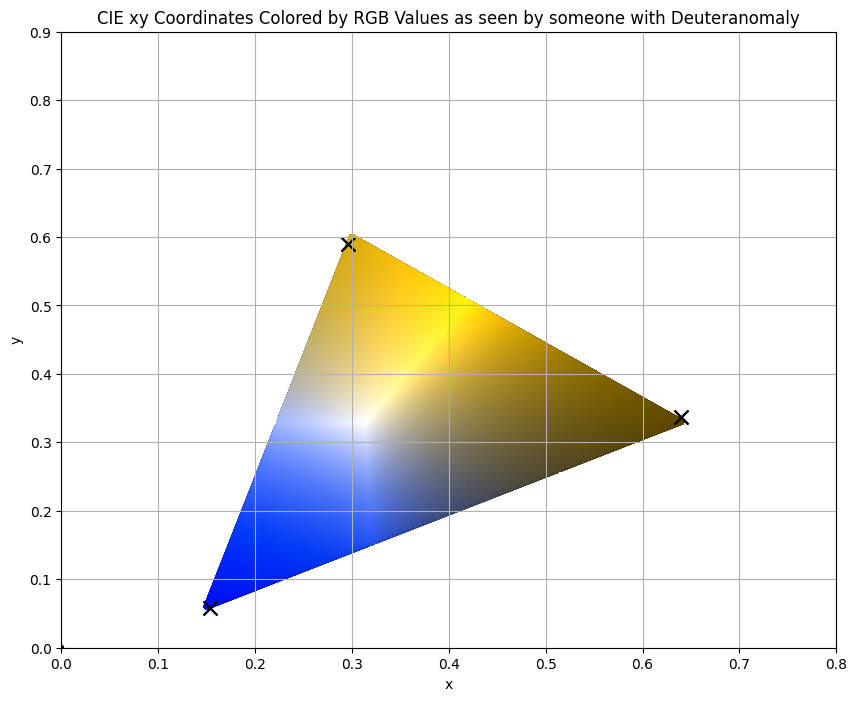

In [34]:
color_vision_deficency = 'Deuteranomaly'

colors_cvd = transform_to_cvd_space(colors, color_vision_deficency)

plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with {color_vision_deficency}', markers=kernel)